In [23]:
import lightgbm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings

from reader import parse

pd.options.mode.chained_assignment = None  # default='warn'
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)

In [24]:
# парсинг данных
df_global = parse()
# фильтрация до 2020 года
df_under_2020 = df_global.loc[:'2019-12-01']  # delete data for 2020
# добавление фичи
df_under_2020.loc[:, ['Time']] = np.arange(len(df_under_2020.index))
df_under_2020.loc[:, 'Lag_1'] = df_under_2020['Signal'].shift(1)

# df_under_2020

In [25]:
# train-test split
def split_train_test_by_month(df, num_m=4):
    y = df['Signal']
    y_train = y[:-num_m]
    y_test = y[-num_m:]

    xdf = df.drop('Signal', inplace=False, axis=1)
    x_train = xdf[:-num_m]
    x_test = xdf[-num_m:]

    return x_train, y_train, x_test, y_test

In [26]:
# LightGBM model
def fit_lightgbm(x_train, y_train, x_test, y_test, n_estimators=100, verbose_eval=50):
    model = lightgbm.LGBMRegressor(
        boosting_type = 'gbdt',
        min_data_in_bin=1,
        min_data_in_leaf=1,
        n_estimators=n_estimators
    )
    model.fit(
        x_train,
        y_train,
        eval_set=[(x_train, y_train), (x_test, y_test)],
        eval_metric='mape',
        verbose=verbose_eval
    )

    return model

In [27]:
# количество месяцев для предсказания
NUM_M = 4

df = df_under_2020.dropna()
df['Signal'] = np.round(df['Signal'], 2)

x_train, y_train, x_test, y_test = split_train_test_by_month(df, NUM_M)

[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[50]	training's mape: 0.00067021	training's l2: 1614.56	valid_1's mape: 0.100142	valid_1's l2: 4.41294e+07
[100]	training's mape: 3.45411e-06	training's l2: 0.042885	valid_1's mape: 0.101473	valid_1's l2: 4.50477e+07


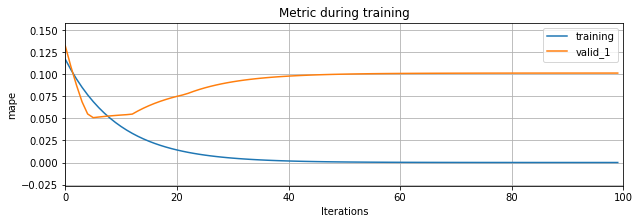

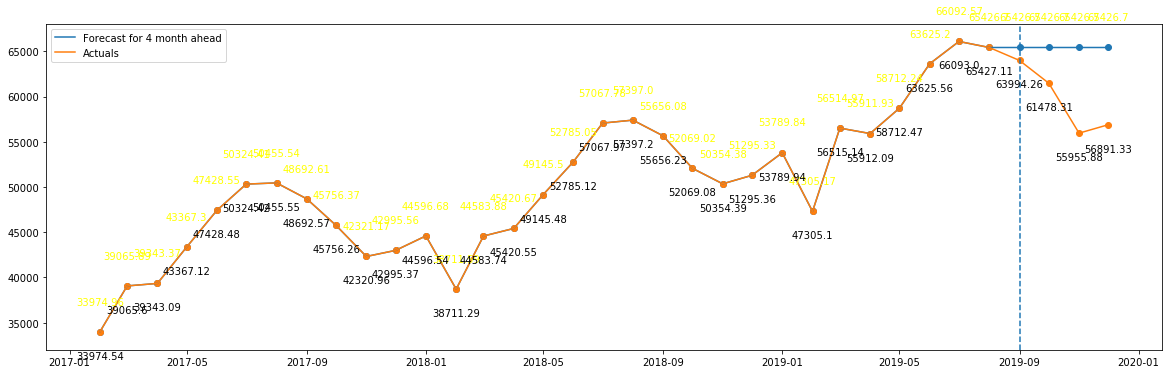

In [28]:
model = fit_lightgbm(x_train, y_train, x_test, y_test)
lightgbm.plot_metric(model, metric='mape', figsize=(10, 3))
forecast = np.round(model.predict(pd.concat([x_train, x_test])), 2)

fig, ax = plt.subplots(1, figsize=(20, 6))
ax.plot(df.index, forecast, label=f'Forecast for {NUM_M} month ahead')
ax.plot(df.index, df['Signal'], label='Actuals')
ax.axvline(x=df.index[int(len(x_train))], linestyle='--')
ax.legend()
plt.scatter(df.index, forecast)
plt.scatter(df.index, df['Signal'])

for i_x, i_y in zip(df.index, forecast):
    plt.text(i_x, i_y + 3000, f'{i_y}', ha='center', color='yellow')

for i_x, i_y in zip(df.index, df['Signal']):
    plt.text(i_x, i_y - 3000, f'{i_y}', ha='center')

plt.show()